The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
DATA_PATH is set to: \\10.34.1.59\big_gulp\nc4_rat_data\Maze_Rats


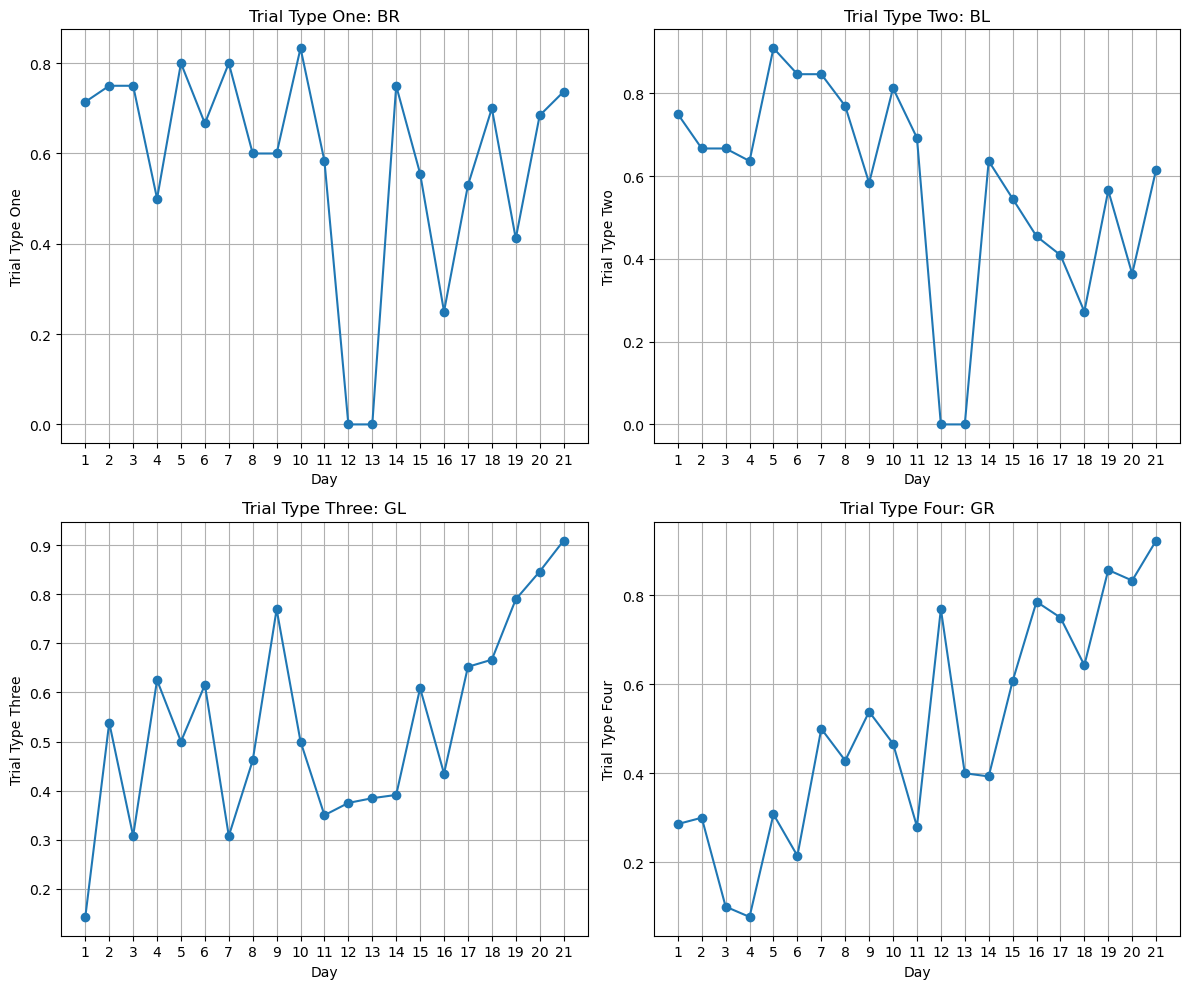

In [20]:
import bagpy
from bagpy import bagreader
import os
import pandas as pd
from dateutil.parser import parse as parsedate
import matplotlib.pyplot as plt
from rosbags.highlevel import AnyReader as RosBagReader
from pathlib import Path
import logging
from dotenv import dotenv_values
from dotenv import load_dotenv
import ast 
import math
from functions import *
import seaborn as sns
from glob import glob

%load_ext autoreload
%autoreload 2

config = dotenv_values()
data_path = os.path.normpath(config['DATA_PATH'])
os.environ['DATA_PATH'] = data_path
print(f"DATA_PATH is set to: {os.environ['DATA_PATH']}")

rat_number = 8
date = '241122'

if isinstance(rat_number, str):
    rat = int(rat_number)

# Look in the specific animal folder based on the number designated to each animal 
anim_folder = os.path.join(data_path, 'NC4%04d' % rat_number)

# Look for a specific date 
if '-' in date:  # e.g. date = '24-Jul-24' 
    date = parsedate(date).strftime('%y%m%d')

date_folder = os.path.join(anim_folder, date)

success_over_days_path = os.path.join(date_folder, 'Success_Over_Days.csv')
save_plots_dir = os.path.join(date_folder, 'plots')

def get_previous_folders(rat, date, path=os.environ['DATA_PATH']):
    if isinstance(rat, str):
        rat = int(rat)

    #look in the specific animal folder based on the number designated to each animal 
    anim_folder = os.path.join(path, 'NC4%04d' % rat)

    # Get list of all folders
    all_folders = sorted([folder for folder in os.listdir(anim_folder) if folder.isdigit()])
    
    # Find index of current_date folder
    try:
        current_index = all_folders.index(date)
    except ValueError:
        raise ValueError(f"The given date {date} does not exist in the folder list.")
    
    # Get the previous three folders including the current one
    start_index = max(current_index - 20, 0)
    return all_folders[start_index:current_index+1]


def calculate_success_rate(rat, date, path=os.environ['DATA_PATH']):
    folders = get_previous_folders(rat, date, path=os.environ['DATA_PATH'])
    if isinstance(rat, str):
        rat = int(rat)

    #look in the specific animal folder based on the number designated to each animal 
    anim_folder = os.path.join(path, 'NC4%04d' % rat)
    # List all CSV files in the specified folder
    
    # Initialize an empty list to store data for the new CSV
    summary_data = []

    # Process each CSV file
    for folder in folders:
        csv_path = os.path.join(anim_folder, folder, 'trial_type_summary.csv')
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
        
            # Calculate success rates for each trial type
            trial_type_one_rate = df.loc[df['Trial Type'] == 1, 'Success_Count'].values[0] / df.loc[df['Trial Type'] == 1, 'Total_Repetitions'].values[0]
            trial_type_two_rate = df.loc[df['Trial Type'] == 2, 'Success_Count'].values[0] / df.loc[df['Trial Type'] == 2, 'Total_Repetitions'].values[0]
            trial_type_three_rate = df.loc[df['Trial Type'] == 3, 'Success_Count'].values[0] / df.loc[df['Trial Type'] == 3, 'Total_Repetitions'].values[0]
            trial_type_four_rate = df.loc[df['Trial Type'] == 4, 'Success_Count'].values[0] / df.loc[df['Trial Type'] == 4, 'Total_Repetitions'].values[0]
            
            # Append the data for the current day to the summary list
            summary_data.append({
                'Day': folders.index(folder)+1,
                'Trial Type One': trial_type_one_rate,
                'Trial Type Two': trial_type_two_rate,
                'Trial Type Three': trial_type_three_rate,
                'Trial Type Four': trial_type_four_rate
            })

    # Create a DataFrame from the summary data
    summary_df = pd.DataFrame(summary_data)

    output_csv_path = os.path.join(anim_folder, date, 'Success_Over_Days.csv')

    # Save the summary DataFrame to a new CSV file
    summary_df.to_csv(output_csv_path, index=False)
    print(f"Summary saved to {output_csv_path}")


calculate_success_rate(9, '241122')

# Load the CSV file into a DataFrame  # Replace with the path to your CSV file
df = pd.read_csv(success_over_days_path)

# Create a figure and a grid of 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot data for each Trial Type
trial_types = ['Trial Type One', 'Trial Type Two', 'Trial Type Three', 'Trial Type Four']
titles = ['Trial Type One: BR', 'Trial Type Two: BL', 'Trial Type Three: GL', 'Trial Type Four: GR']
day_values = df['Day']

# Iterate over the subplots and plot each Trial Type
for i, ax in enumerate(axs.flatten()):
    ax.plot(day_values, df[trial_types[i]], marker='o')
    ax.set_title(titles[i])
    ax.set_xlabel('Day')
    ax.set_ylabel(trial_types[i])
    ax.grid(True)

    ax.set_xticks(day_values)
    ax.set_xticklabels(day_values)

# Adjust layout to avoid overlap
plt.tight_layout()

file_name = 'Success_Over_Days.png'
save_path = os.path.join(save_plots_dir, file_name)

# Save the plot to the defined path
plt.savefig(save_path)
plt.show()


